# SSAC - Exploration 17 - Session Based Recommendation
---
Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작.

## 데이터 셋 불러오기

In [1]:
import datetime as dt
from pathlib import Path
import os
from datetime import datetime
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## Step 1. 데이터의 전처리

항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.    
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [3]:
# 전체 데이터 길이
len(data)

1000209

In [4]:
# 중복데이터 검사
data.duplicated().sum()

0

In [5]:
#추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수 입니다.
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [6]:
# 각 아이디 별 평점 데이터 몇개정도를 갖는지도 살펴보겠습니다.
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
user_length.median(), user_length.mean(), user_length.std()

(96.0, 165.5975165562914, 192.74702906977777)

In [8]:
user_length.min(), user_length.max()

(20, 2314)

+ 아이디별 평점을 준 기록의 표준편차가 192로 평균이 165으로 데이터가 상당히 넓게 분포되어 있는 것으로 보인다.
  + 익명의 사용자의 접속데이터인 session이 대부분 하루 특정 시간대에 접속 후 짧은 시간 내에 sequence가 끝나는 짧은 기간의 데이터 였던 반면 영화 평점 데이터는 아이디 별로 장기간에 걸쳐 축적될 수 있는 형태의 데이터이기 때문에 세션 기반 추천 시스템을 학습시키기 위해서 세션과 유사한 형태로 구성하기 위한 고민이 필요해 보인다. 
+ 상품 구매 행태는 한달을 주기로 변화하는 특성이 있다고 하나 영화 선호의 경우 동일한 직관을 적용할 수 있는지는 의문이다. 영화 선호는 시기에 종속된다기 보다는 사용자의 취향에 좀 더 영향을 많이 받을 것 같은데 세션 기반 추천 시스템을 구성하면서 좋은 성능을 달성하기 위해 데이터를 어떤 형태로 구성해야 할지 고민이 필요해 보인다. 
  + 주어진 데이터는 영화나 사용자의 아이디만 가지고 있어 사용자와 영화의 특성을 특정하여 유사한 군집을 만들 수가 없다.
  + 임의의 특정 사용자의 영화 취향이 시기에 따라 변화하는 경우와 변화하지 않는 경우에 모델 구성이 달라야 할 것 같다.
+ 전체 데이터가 어느 정도의 기간에 걸쳐 수집된 데이터인지를 살펴보고 임의로 기간을 나눠서 살펴보기로 한다.
  + 주어진 데이터의 시간 기록은 unix시간으로 기록되어 있다고 하니 알아보기 쉽게 변환이 필요하다.

In [9]:
# 시간 변환 방법 : 유닉스 시간을 문자열 형태로 표현하고 문자열을 다시 datetime 객채로 변환하였다.
time_stamp = data['Time'][100]

print(datetime.strptime(datetime.utcfromtimestamp(time_stamp).strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S'))
type(datetime.strptime(datetime.utcfromtimestamp(time_stamp).strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S'))

2000-12-31 21:40:14


datetime.datetime

In [10]:
data['datetime'] = data['Time'].map(lambda x : datetime.strptime(datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S'))
data

,UserId,ItemId,Rating,Time,datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [11]:
data['datetime'].max(), data['datetime'].min()

(Timestamp('2003-02-28 17:49:50'), Timestamp('2000-04-25 23:05:32'))

+ 2000년 4월부터 2003년 2월까지 수집한 데이터이다.

In [12]:
# 처음 시작 달을 0으로 경과한 달을 세는 함수를 만들어 본다.
def calculate_by_month(time_stamp, start_datetime):
    return ((time_stamp.year - start_datetime.year) * 12) + time_stamp.month - start_datetime.month

start_datetime = data['datetime'].min()

In [13]:
# 랜덤으로 지정하여 함수가 잘 작동하는지 본다.
import random
temp = data['datetime'][random.randrange(0,len(data))]
print(temp)
calculate_by_month(temp, start_datetime)

2000-11-21 20:02:07


7

In [14]:
# map() 을 이용해 달을 세어 새로운 열을 만들어 준다.
data['month'] = data['datetime'].map(lambda x : calculate_by_month(x, start_datetime))
data.head(3)

,UserId,ItemId,Rating,Time,datetime,month
31,1,3186,4,978300019,2000-12-31 22:00:19,8
22,1,1270,5,978300055,2000-12-31 22:00:55,8
27,1,1721,4,978300055,2000-12-31 22:00:55,8


In [15]:
data.month.max()

34

In [16]:
# 월별 레이팅 기록 수
data.groupby(['month']).count()

,UserId,ItemId,Rating,Time,datetime
month,,,,,
0,11396,11396,11396,11396,11396
1,67437,67437,67437,67437,67437
2,54486,54486,54486,54486,54486
3,90334,90334,90334,90334,90334
4,182109,182109,182109,182109,182109
5,52421,52421,52421,52421,52421
6,42294,42294,42294,42294,42294
7,290793,290793,290793,290793,290793
8,113487,113487,113487,113487,113487


<AxesSubplot:>

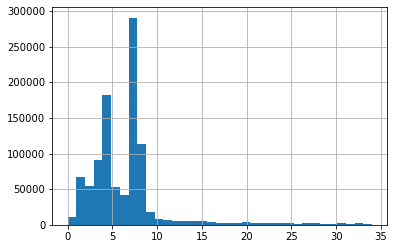

In [17]:
data['month'].hist(bins=35)

+ 대부분의 평점 데이터가 7~8번째 달에 몰려 있다. 
  + 단순히 기간으로 데이터를 선택해 사용하고자 하면 선택 기준을 세우기가 어려워 보인다.
    + 데이터가 몰려 있는 구간을 선택하게 되면 가장 나중 데이터를 상실하게 될 수 있다.
    + 가장 나중의 데이터를 선택하면 상당한 데이터를 상실하게 될 수 있다.
    + 최대한 데이터를 사용하고자 한다면 상당히 긴 기간동안의 데이터를 선택하게 되며 사용자간 활동 기간의 시점과 기간이 달라져 아이디 별로 일관된 세션을 구성하기가 어려워 보인다.

In [18]:
def get_user_active_period(df):
    temp = {}
    temp['active_period'] = df['month'].max() - df['month'].min()
    return pd.Series(temp)

In [19]:
user_active_period = data.groupby(['UserId']).apply(get_user_active_period)

In [20]:
user_active_period

,active_period
UserId,
1,1
2,0
3,0
4,0
5,0
...,...
6036,0
6037,0
6038,0


In [21]:
user_active_period.value_counts()

active_period
0                4365
1                 341
2                 168
3                  85
4                  66
27                 61
5                  61
26                 59
7                  52
6                  51
8                  47
9                  42
25                 42
14                 41
24                 39
13                 39
15                 36
16                 36
10                 34
22                 33
18                 32
12                 32
19                 31
17                 30
29                 29
30                 28
20                 27
23                 27
28                 27
11                 24
31                 17
32                 15
21                 15
33                  8
dtype: int64

array([[<AxesSubplot:title={'center':'active_period'}>]], dtype=object)

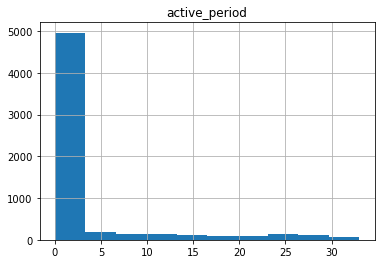

In [22]:
user_active_period.hist()

In [23]:
user_active_period.value_counts().sum()

6040

In [24]:
(user_active_period.value_counts().max() / user_active_period.value_counts().sum()) * 100

72.26821192052981

+ 1달간만 활동한 사용자가 전체의 72%로 상당한 비중을 차지한다.
  + 이러한 사용자의 데이터만 활용한다면 월 별로 데이터를 잘라서 사용해도 유사한 기간 동안 사용자들의 선택을 session으로 쉽게 구성할 수 있을 것 같다. 
  + 해당 사용자의 월별 분포를 살펴보기로 하자.

In [25]:
user_active_period.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040],
           dtype='int64', name='UserId', length=6040)

In [26]:
one_month_user = user_active_period[user_active_period['active_period']==0].index

In [27]:
one_month_user

Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   12,   13,
            ...
            6030, 6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039],
           dtype='int64', name='UserId', length=4365)

In [28]:
temp = data[data['UserId'].isin(one_month_user)]
temp

,UserId,ItemId,Rating,Time,datetime,month
130,2,1198,4,978298124,2000-12-31 21:28:44,8
64,2,1210,4,978298151,2000-12-31 21:29:11,8
71,2,1217,3,978298151,2000-12-31 21:29:11,8
134,2,2717,3,978298196,2000-12-31 21:29:56,8
88,2,1293,5,978298261,2000-12-31 21:31:01,8
...,...,...,...,...,...,...
999798,6039,1148,4,956758002,2000-04-26 14:06:42,0
999764,6039,912,4,956758029,2000-04-26 14:07:09,0
999771,6039,922,5,956758029,2000-04-26 14:07:09,0
999815,6039,1204,5,956758029,2000-04-26 14:07:09,0


In [29]:
pd.DataFrame(temp.groupby(['UserId']).mean()['month']).value_counts()

month
7.0      1532
4.0       863
8.0       489
3.0       447
1.0       330
2.0       268
5.0       215
6.0       163
0.0        56
31.0        1
13.0        1
dtype: int64

+ 이 데이터도 7월에 몰려 있다. 전반적인 데이터가 7월에 몰려있는데 한달만 활동한 사용자가 여러 달에 골고루 들어 있지 않을까 했던게 실수였다.
   + 사용 기간을 한달로 정해 영화 평점 데이터를 단기간 동안 쇼핑 사이트에 접속하여 상품을 클릭한 세션 데이터와 유사하게 만들고자 했던 건 전체적인 데이터의 분포를 무시한 안일한 생각이었다.
   + 영화 평점 평가 사이트의 데이터 분포와 쇼핑 사이트 세션 기록 분포의 차이도 생각하지 않고 막연히 유사해지지 않을까 기대했던 것 같다.

In [30]:
cond = data['UserId'] == 2
data[cond]['Time'].duplicated().sum()

63

In [31]:
def get_duplicated_timestamp(df):
    temp = {}
    if df['Time'].duplicated().sum() > 0:
        temp['duplicated_timestamp'] = 1
    else:
        temp['duplicated_timestamp'] = 0
    return pd.Series(temp)

In [32]:
duplicated_timestamp = data.groupby(['UserId']).apply(get_duplicated_timestamp)
duplicated_timestamp.value_counts()

duplicated_timestamp
1                       6038
0                          2
dtype: int64

+ Time이 초까지 겹치는 데이터가 발생하는 것이 이상한 일은 아닌 모양이다.

---
+ 세션을 어떻게 나눌지에 대해 계속 고민해 봤지만 장기간 계속 사용한 사용자의 특성도 유지하면서 timestamp가 찍힌 실제 시기도 반영하고 유사한 길이의 session으로 구성하는 것은 어려울 것 같다.
   + 목적을 다시 상기해 보자면 새로운 사용자가 선호하는 영화를 추천하는 것이 목적이다.
   + 비선호 영화는 선택 기록에서 제거하기로 한다.
     + rating 점수가 낮은 것은 선호하지 않음을 표현한 것으로 간주하고 기록에서 제거하기로 한다. rating 2점 이하는 비선호로 판단한다.
     + 사람들이 rating으로 평가한 횟수가 적은 영화도 선호도가 낮은 영화로 간주하고 기록에서 제거하기로 한다.
   + 이상한 사용자는 기록에서 제거하기로 한다.
     + timestamp 기록을 보고 정상적 사용자가 아니라고 판단되는 기록은 제거하기로 한다.
   + 영화 선호가 시기에 따라 급변할 것 같지는 않다. 
     + 데이터가 뭉쳐 있는 초반의 데이터를 무시할 필요는 없을 것 같다. 신규 사용자가 예전 영화로 자신의 선호를 드러낼 수도 있다.
     + 예전 데이터에는 없던 새로 개봉한 영화에 대한 선호를 학습 데이터로 확보할 필요가 있으므로 최대한 나중의 데이터도 확보할 필요가 있다.
     + 신규 사용자에 대한 영화 추천이 목적이라면 노드에서 구성한 것과 같이 가장 최근의 데이터를 test로 그 직전의 데이터를 validation으로 설정하는 것이 좋겠다.
     + 연 단위로 하면 데이터 간 시점의 차이가 크므로 월 단위로 잘라서 최근 월의 데이터의 양을 살펴본 후 적정량을 test, validation으로 구성하기로 한다. 
   + 월 단위로 자르면 한 아이디로 월에 걸쳐 형성된 sequence 데이터가 test, train, validation에 섞여 들어갈 수 있다.
     + 장기 사용자의 선택이 월으로 나눔으로 인해 train, test, validation에 골고루 섞여 들어간다 하더라도 예전에 평점을 준 영화에 또 평점을 주지는 않을 것이므로 독립적인 별개의 사용자로 볼 수도 있지 않을까?
   + 한 session의 길이?
     + 월 별로 데이터를 잘라보고 최대 길이를 정해보기로 한다. 가능한 원 데이터에서 최소단위 였던 20 근처에서 맞춰본다.

In [33]:
# rating이 3점 이상인 영화만 남김
cond = data['Rating']>2
data = data[cond]
data

,UserId,ItemId,Rating,Time,datetime,month
31,1,3186,4,978300019,2000-12-31 22:00:19,8
22,1,1270,5,978300055,2000-12-31 22:00:55,8
27,1,1721,4,978300055,2000-12-31 22:00:55,8
37,1,1022,5,978300055,2000-12-31 22:00:55,8
24,1,2340,3,978300103,2000-12-31 22:01:43,8
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,16
999988,6040,1921,4,997454464,2001-08-10 14:41:04,16
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,16
1000167,6040,161,3,997454486,2001-08-10 14:41:26,16


In [34]:
# 영화별 rating이 기록된 횟수
movie_popular = data.groupby('ItemId').size()
movie_popular

ItemId
1       2000
2        551
3        339
4        102
5        214
        ... 
3948     752
3949     280
3950      47
3951      36
3952     353
Length: 3628, dtype: int64

In [35]:
# 최소 선택 영화, 최대 선택 영화, 평균, 표준편차
movie_popular.min(), movie_popular.max(), movie_popular.mean(), movie_popular.std()

(1, 3211, 230.56174200661522, 355.59639328683835)

<AxesSubplot:ylabel='Density'>

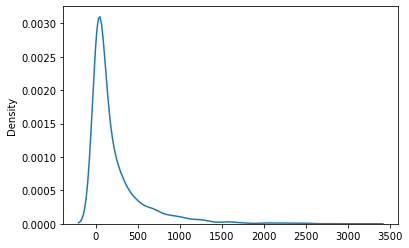

In [36]:
import seaborn as sns
sns.kdeplot(movie_popular)

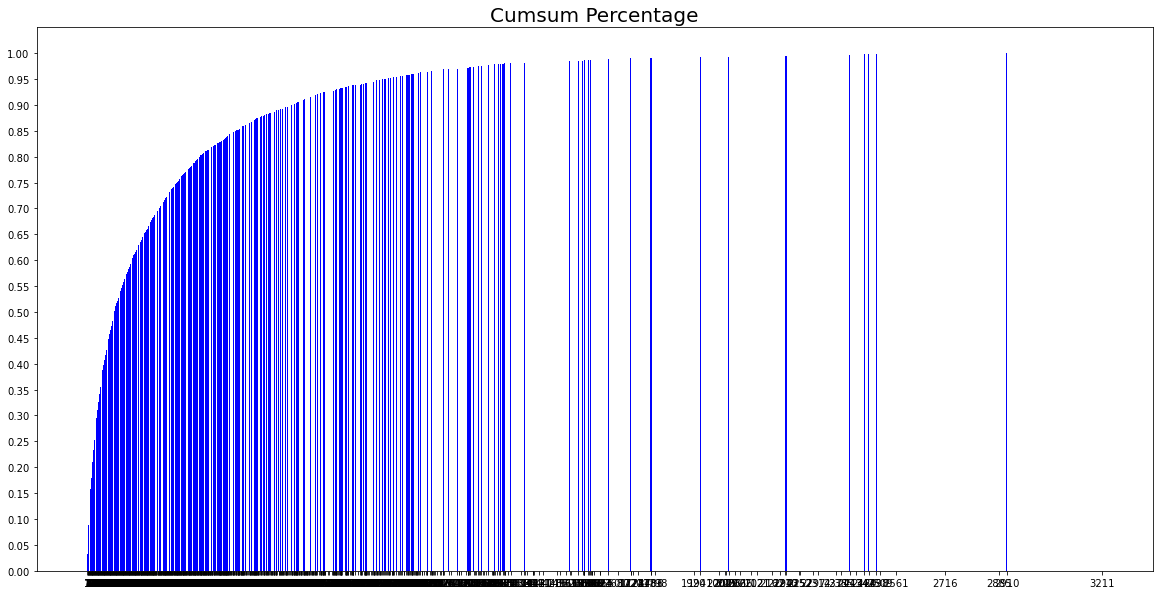

In [37]:
popularity_count = movie_popular.groupby(movie_popular).size()
popularity_percent_cumsum = popularity_count.cumsum() / popularity_count.sum()

plt.figure(figsize=(20, 10))
plt.bar(x=popularity_percent_cumsum.index,
        height=popularity_percent_cumsum, color='blue')
plt.xticks(popularity_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage', size=20)
plt.show()

In [38]:
popularity_percent_cumsum_01 = popularity_percent_cumsum[popularity_percent_cumsum < 0.1]
popularity_percent_cumsum_01

1    0.032800
2    0.057056
3    0.074421
4    0.088479
5    0.098126
dtype: float64

+ 2번 선택된 것 까지 제거하여 약 5% 의 아이템을 제거 하기로 한다. 

In [39]:
less_fav = movie_popular[movie_popular==1]
less_fav

ItemId
98      1
138     1
139     1
192     1
286     1
       ..
3842    1
3876    1
3881    1
3890    1
3899    1
Length: 119, dtype: int64

In [40]:
less_fav_list = less_fav.index
less_fav_list

Int64Index([  98,  138,  139,  192,  286,  311,  396,  398,  401,  402,
            ...
            3748, 3772, 3779, 3800, 3828, 3842, 3876, 3881, 3890, 3899],
           dtype='int64', name='ItemId', length=119)

In [41]:
data = data[~data['ItemId'].isin(less_fav_list)]
data

,UserId,ItemId,Rating,Time,datetime,month
31,1,3186,4,978300019,2000-12-31 22:00:19,8
22,1,1270,5,978300055,2000-12-31 22:00:55,8
27,1,1721,4,978300055,2000-12-31 22:00:55,8
37,1,1022,5,978300055,2000-12-31 22:00:55,8
24,1,2340,3,978300103,2000-12-31 22:01:43,8
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,16
999988,6040,1921,4,997454464,2001-08-10 14:41:04,16
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,16
1000167,6040,161,3,997454486,2001-08-10 14:41:26,16


In [42]:
less_fav = movie_popular[movie_popular==2]
less_fav

ItemId
120     2
130     2
134     2
439     2
530     2
       ..
3595    2
3601    2
3603    2
3631    2
3888    2
Length: 88, dtype: int64

In [43]:
less_fav_list = less_fav.index
less_fav_list

Int64Index([ 120,  130,  134,  439,  530,  557,  578,  582,  623,  657,  666,
             679,  698,  703,  712,  729,  734,  791,  796,  815,  827,  834,
             847,  884,  981, 1070, 1098, 1134, 1139, 1170, 1364, 1383, 1434,
            1495, 1538, 1622, 1636, 1795, 1796, 1842, 1851, 1877, 1886, 1891,
            1989, 2198, 2234, 2244, 2251, 2309, 2480, 2543, 2631, 2754, 2777,
            2811, 2823, 2825, 2869, 2895, 2934, 3057, 3084, 3131, 3136, 3187,
            3216, 3233, 3295, 3305, 3336, 3337, 3352, 3353, 3373, 3377, 3380,
            3381, 3413, 3482, 3517, 3573, 3575, 3595, 3601, 3603, 3631, 3888],
           dtype='int64', name='ItemId')

In [44]:
data = data[~data['ItemId'].isin(less_fav_list)]
data

,UserId,ItemId,Rating,Time,datetime,month
31,1,3186,4,978300019,2000-12-31 22:00:19,8
22,1,1270,5,978300055,2000-12-31 22:00:55,8
27,1,1721,4,978300055,2000-12-31 22:00:55,8
37,1,1022,5,978300055,2000-12-31 22:00:55,8
24,1,2340,3,978300103,2000-12-31 22:01:43,8
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,16
999988,6040,1921,4,997454464,2001-08-10 14:41:04,16
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,16
1000167,6040,161,3,997454486,2001-08-10 14:41:26,16


In [45]:
# 각 아이디 별 평점 데이터 몇개정도를 갖는지도 살펴보겠습니다.
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    276
Length: 6039, dtype: int64

In [46]:
user_length.min(), user_length.max(), user_length.mean(), user_length.std()

(1, 1944, 138.46381851299884, 156.12773764176876)

In [47]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()

length_percent_cumsum

1       0.000166
7       0.000331
9       0.000994
10      0.001159
11      0.001987
          ...   
1144    0.999338
1145    0.999503
1513    0.999669
1712    0.999834
1944    1.000000
Length: 642, dtype: float64

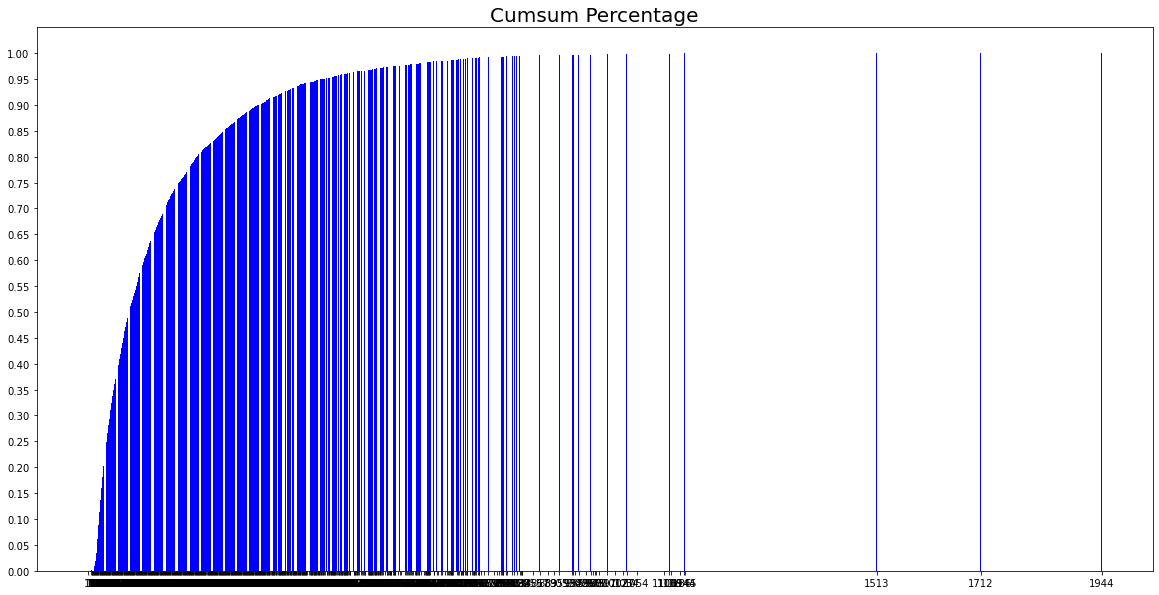

In [48]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum.index,
        height=length_percent_cumsum, color='blue')
plt.xticks(length_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage', size=20)
plt.show()

In [49]:
user_length[user_length==1944]

UserId
4169    1944
dtype: int64

In [50]:
long_history = user_length[user_length==1944].index[0]
data[data['UserId']==long_history]

,UserId,ItemId,Rating,Time,datetime,month
696969,4169,1268,5,965333392,2000-08-03 20:09:52,4
697168,4169,2617,4,965333392,2000-08-03 20:09:52,4
697185,4169,2628,4,965333392,2000-08-03 20:09:52,4
697219,4169,2653,4,965333392,2000-08-03 20:09:52,4
697275,4169,423,3,965333392,2000-08-03 20:09:52,4
...,...,...,...,...,...,...
696870,4169,3916,4,1018211900,2002-04-07 20:38:20,24
697272,4169,2691,3,1024172088,2002-06-15 20:14:48,26
697055,4169,3207,3,1024172606,2002-06-15 20:23:26,26
695702,4169,1413,3,1024175031,2002-06-15 21:03:51,26


In [51]:
data[data['UserId']==long_history]['month'].value_counts()

6     562
8     478
4     443
7     213
9      75
5      72
10     22
11     21
19      9
22      7
17      7
15      7
13      7
12      6
23      6
21      4
26      4
24      1
Name: month, dtype: int64

<AxesSubplot:>

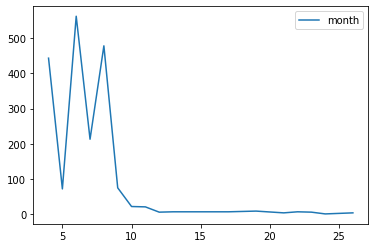

In [52]:
pd.DataFrame(data[data['UserId']==long_history]['month'].value_counts()).sort_index().plot()

In [53]:
temp = data[data['UserId']==long_history]
temp[temp['month']==6]

,UserId,ItemId,Rating,Time,datetime,month
696349,4169,3893,5,971578194,2000-10-15 02:49:54,6
696354,4169,3897,5,971578194,2000-10-15 02:49:54,6
696275,4169,3853,4,971578220,2000-10-15 02:50:20,6
696274,4169,3852,4,971578241,2000-10-15 02:50:41,6
696295,4169,3863,4,971578267,2000-10-15 02:51:07,6
...,...,...,...,...,...,...
696661,4169,17,5,971582323,2000-10-15 03:58:43,6
696723,4169,34,4,971582323,2000-10-15 03:58:43,6
697566,4169,1730,4,971582323,2000-10-15 03:58:43,6
697569,4169,1733,3,971582323,2000-10-15 03:58:43,6


In [54]:
temp[temp['month']==6]['datetime'].max() - temp[temp['month']==6]['datetime'].min()

Timedelta('0 days 01:08:49')

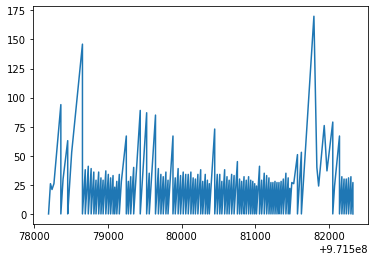

In [55]:
# 시간 차분으로 평가 사이사이 걸린 시간을 확인함
x = temp[temp['month']==6]['Time']
y = temp[temp['month']==6]['Time'].diff()
plt.plot(x,y)

In [56]:
y.max(), y.min(), y.mean(), y.median(), y.std()

(170.0, 0.0, 7.360071301247772, 0.0, 18.160458694507334)

<AxesSubplot:xlabel='Time', ylabel='Density'>

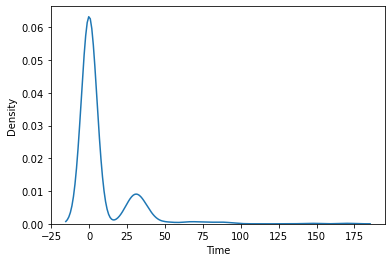

In [57]:
sns.kdeplot(y)

In [58]:
temp[temp['month']==8]

,UserId,ItemId,Rating,Time,datetime,month
696869,4169,3914,4,975802901,2000-12-03 00:21:41,8
696957,4169,3948,4,975802901,2000-12-03 00:21:41,8
696447,4169,3150,4,975803036,2000-12-03 00:23:56,8
696291,4169,648,4,975803060,2000-12-03 00:24:20,8
696959,4169,3949,5,975803116,2000-12-03 00:25:16,8
...,...,...,...,...,...,...
697023,4169,765,3,976590102,2000-12-12 03:01:42,8
696101,4169,2822,3,976590130,2000-12-12 03:02:10,8
697779,4169,504,3,976590130,2000-12-12 03:02:10,8
696700,4169,2906,3,976590169,2000-12-12 03:02:49,8


In [59]:
temp[temp['month']==8]['datetime'].max() - temp[temp['month']==8]['datetime'].min()

Timedelta('9 days 02:41:08')

+ 선택 사이사이 걸린 시간을 보면 0초가 가장 많으나 원 데이터에서도 0초가 가장 많은 데이터 였으므로 큰 문제는 없는 것 같다.
    + 헤딩 데이터를 수집한 사이트에서 어떻게 데이터가 집계되는지 알 수 없으므로 보수적으로 판단하기로 한다.
---

In [60]:
# 두번째로 평가 많은 아이디
long_history = user_length[user_length==1712].index[0]
data[data['UserId']==long_history]

,UserId,ItemId,Rating,Time,datetime,month
712941,4277,2841,4,965289972,2000-08-03 08:06:12,4
713457,4277,1210,4,965289972,2000-08-03 08:06:12,4
713909,4277,2311,4,965289972,2000-08-03 08:06:12,4
713369,4277,356,5,965290019,2000-08-03 08:06:59,4
714119,4277,1003,4,965290019,2000-08-03 08:06:59,4
...,...,...,...,...,...,...
714033,4277,1744,3,1045103679,2003-02-13 02:34:39,34
713397,4277,3581,4,1045501780,2003-02-17 17:09:40,34
713223,4277,2544,3,1045786097,2003-02-21 00:08:17,34
713899,4277,2307,3,1046193234,2003-02-25 17:13:54,34


In [61]:
data[data['UserId']==long_history]['month'].value_counts()

4     1044
7      155
11     109
8       98
5       93
6       34
9       20
10      19
29      14
13      12
12      10
34      10
21       8
16       8
18       8
15       7
20       7
25       7
27       7
17       6
23       6
33       5
14       5
32       5
24       4
19       3
28       3
22       2
26       2
31       1
Name: month, dtype: int64

<AxesSubplot:>

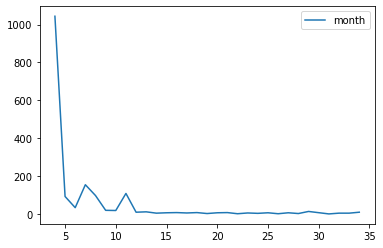

In [62]:
pd.DataFrame(data[data['UserId']==long_history]['month'].value_counts()).sort_index().plot()

+ 첫달 많은 평가를 하고 이후엔 조금씩 평가를 추가해 가는 형태이다. 첫 달에 날짜별 평가진행상황을 검토해 본다.

In [63]:
temp = data[data['UserId']==long_history]
temp[temp['month']==4]

,UserId,ItemId,Rating,Time,datetime,month
712941,4277,2841,4,965289972,2000-08-03 08:06:12,4
713457,4277,1210,4,965289972,2000-08-03 08:06:12,4
713909,4277,2311,4,965289972,2000-08-03 08:06:12,4
713369,4277,356,5,965290019,2000-08-03 08:06:59,4
714119,4277,1003,4,965290019,2000-08-03 08:06:59,4
...,...,...,...,...,...,...
712673,4277,2096,5,967623102,2000-08-30 08:11:42,4
713360,4277,1964,4,967623102,2000-08-30 08:11:42,4
713379,4277,1971,4,967623102,2000-08-30 08:11:42,4
713885,4277,1345,5,967623102,2000-08-30 08:11:42,4


In [64]:
temp['ymd'] = temp['datetime'].map(lambda x : x.strftime('%Y-%m-%d'))
temp[temp['month']==4]['ymd'].value_counts()

2000-08-03    288
2000-08-30    219
2000-08-24    148
2000-08-04    130
2000-08-05    110
2000-08-07     89
2000-08-16     48
2000-08-11      5
2000-08-14      5
2000-08-20      2
Name: ymd, dtype: int64

In [65]:
# 8월 3일 전체 평가에 걸린 시간
temp[temp['ymd']=='2000-08-03']['datetime'].max() - temp[temp['ymd']=='2000-08-03']['datetime'].min()

Timedelta('0 days 01:23:13')

In [66]:
# 8월 30일 전체 평가에 걸린 시간
temp[temp['ymd']=='2000-08-30']['datetime'].max() - temp[temp['ymd']=='2000-08-30']['datetime'].min()

Timedelta('0 days 01:08:09')

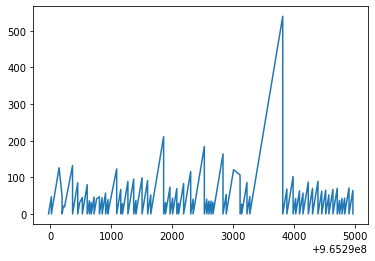

In [67]:
# 시간 차분으로 평가 사이사이 걸린 시간을 확인함
x = temp[temp['ymd']=='2000-08-03']['Time']
y = temp[temp['ymd']=='2000-08-03']['Time'].diff()
plt.plot(x,y)

In [68]:
# 540초가 걸린 선택이 가장 긴 차이이고 평균적으로 17초 중간 값은 0초 이다.
y.max(), y.min(), y.mean(), y.median(), y.std()

(540.0, 0.0, 17.39721254355401, 0.0, 45.749573645078)

<AxesSubplot:xlabel='Time', ylabel='Density'>

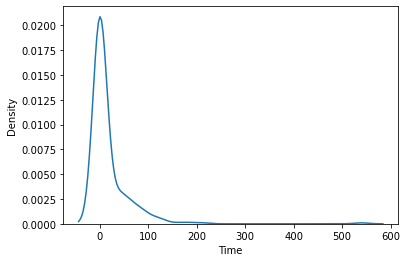

In [69]:
sns.kdeplot(y)

In [70]:
y.value_counts()

0.0      218
47.0       3
35.0       2
31.0       2
57.0       2
67.0       2
89.0       2
37.0       2
43.0       2
40.0       2
52.0       2
42.0       2
70.0       2
86.0       1
36.0       1
123.0      1
20.0       1
39.0       1
44.0       1
41.0       1
46.0       1
62.0       1
80.0       1
28.0       1
45.0       1
30.0       1
85.0       1
132.0      1
19.0       1
21.0       1
49.0       1
126.0      1
65.0       1
87.0       1
63.0       1
27.0       1
95.0       1
106.0      1
121.0      1
53.0       1
164.0      1
32.0       1
540.0      1
184.0      1
68.0       1
116.0      1
83.0       1
29.0       1
69.0       1
102.0      1
73.0       1
211.0      1
71.0       1
91.0       1
99.0       1
1.0        1
64.0       1
Name: Time, dtype: int64

+ 선택 사이사이 걸린 시간을 보면 0초가 가장 많으나 원 데이터에서도 0초가 가장 많은 데이터 였으므로 큰 문제는 없는 것 같다.
  + 헤딩 데이터를 수집한 사이트에서 어떻게 데이터가 집계되는지 알 수 없으므로 보수적으로 판단하기로 한다.
---

In [71]:
# 세번째로 평가 많은 아이디
long_history = user_length[user_length==1513].index[0]
data[data['UserId']==long_history]

,UserId,ItemId,Rating,Time,datetime,month
278445,1680,3940,3,974708446,2000-11-20 08:20:46,7
279596,1680,2395,4,974708446,2000-11-20 08:20:46,7
278591,1680,3051,3,974708506,2000-11-20 08:21:46,7
279652,1680,1762,3,974708506,2000-11-20 08:21:46,7
280002,1680,376,4,974708506,2000-11-20 08:21:46,7
...,...,...,...,...,...,...
279465,1680,880,4,974844847,2000-11-21 22:14:07,7
280121,1680,540,4,974844847,2000-11-21 22:14:07,7
278469,1680,1266,5,974844953,2000-11-21 22:15:53,7
279644,1680,3508,4,974844968,2000-11-21 22:16:08,7


In [72]:
data[data['UserId']==long_history]['month'].value_counts()

7    1513
Name: month, dtype: int64

In [73]:
temp = data[data['UserId']==long_history]
temp['ymd'] = temp['datetime'].map(lambda x : x.strftime('%Y-%m-%d'))
temp['ymd'].value_counts()

2000-11-20    798
2000-11-21    715
Name: ymd, dtype: int64

+ 연속된 이틀간 데이터가 많이 입력되고 이후 없으므로 이상치로 간주한다.

In [74]:
# 데이터 제거
data = data[data['UserId']!=1680]
long_history = user_length[user_length==1513].index[0]
data[data['UserId']==long_history]

,UserId,ItemId,Rating,Time,datetime,month


In [75]:
data['ymd'] = data['datetime'].map(lambda x : x.strftime('%Y-%m-%d'))

In [76]:
data.groupby(['UserId', 'ymd']).count().mean()

ItemId      38.159832
Rating      38.159832
Time        38.159832
datetime    38.159832
month       38.159832
dtype: float64

In [77]:
data.groupby(['UserId', 'ymd']).count().median()

ItemId      7.0
Rating      7.0
Time        7.0
datetime    7.0
month       7.0
dtype: float64

<AxesSubplot:>

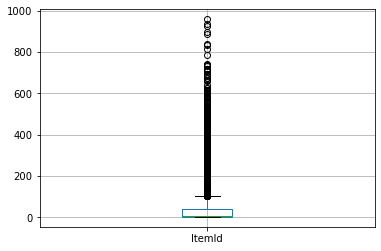

In [78]:
data.groupby(['UserId', 'ymd']).count().boxplot(['ItemId'])

In [79]:
temp = data.groupby(['month', 'UserId']).count()['ItemId'].reset_index()
temp['ItemId'].value_counts()

1       1403
2        925
3        654
4        468
5        374
        ... 
443        1
435        1
427        1
379        1
1027       1
Name: ItemId, Length: 569, dtype: int64

In [80]:
temp = data.groupby(['UserId', 'ymd']).count()['ItemId'].reset_index()

In [81]:
temp['ItemId'].value_counts()

1      5837
2      2197
3      1107
4       746
5       551
       ... 
582       1
566       1
534       1
470       1
423       1
Name: ItemId, Length: 498, dtype: int64

+ 전체 데이터를 모두 월별로 나누어 아이디 별로 rating 기록 횟수를 세면 1403개의 데이터의 길이가 1로 많은 데이터가 쓸모가 없어진다.
  + 아이디와 일별로 세면 5837개의 데이터의 길이가 1이 된다.
  + test, validation으로 사용할 달에서만 길이가 1인 데이터를 삭제해 주고 훈련 데이터는 전 구간을 하나로 보고 필요 길이만큼 잘라서 사용하도록 한다.

In [82]:
movie_month = data['month'].unique()

In [83]:
movie_month.sort()

In [84]:
movie_month

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [85]:
test_month = movie_month[-4:]
test_month

array([31, 32, 33, 34])

In [86]:
test = data[data['month'].isin(test_month)]

In [87]:
test.groupby(['UserId']).count().reset_index()['ItemId'].value_counts()

1      43
2      32
3      24
4      15
6      15
       ..
38      1
29      1
31      1
262     1
452     1
Name: ItemId, Length: 63, dtype: int64

In [88]:
len(test) / len(data) * 100

0.6407322654462242

In [89]:
len(test)

5348

In [90]:
len(data)

834670

In [91]:
val_month = movie_month[-8:-4]
val_month

array([27, 28, 29, 30])

In [92]:
val = data[data['month'].isin(val_month)]
val.groupby(['UserId']).count().reset_index()['ItemId'].value_counts()

1     34
2     28
3     25
7     18
4     14
      ..
51     1
48     1
46     1
42     1
34     1
Name: ItemId, Length: 64, dtype: int64

In [93]:
len(val)

5085

In [94]:
len(val) / len(data) * 100

0.6092228066181845

In [95]:
train_month = movie_month[:-8]
train_month

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [96]:
train = data[data['month'].isin(train_month)]
train.groupby(['UserId']).count().reset_index()['ItemId'].value_counts()

22      88
20      86
24      84
21      80
26      76
        ..
981      1
997      1
10       1
1135     1
4        1
Name: ItemId, Length: 640, dtype: int64

+ 후반부의 데이터가 적어 각기 전체 기간 중 약 10%인 4개월 씩을 test, validation dataset으로 할당했다.

In [97]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train = indexing(train, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [98]:
train 

,UserId,ItemId,Rating,Time,datetime,month,ymd,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,8,2000-12-31,0
22,1,1270,5,978300055,2000-12-31 22:00:55,8,2000-12-31,1
27,1,1721,4,978300055,2000-12-31 22:00:55,8,2000-12-31,2
37,1,1022,5,978300055,2000-12-31 22:00:55,8,2000-12-31,3
24,1,2340,3,978300103,2000-12-31 22:01:43,8,2000-12-31,4
...,...,...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,16,2001-08-10,1104
999988,6040,1921,4,997454464,2001-08-10 14:41:04,16,2001-08-10,315
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,16,2001-08-10,87
1000167,6040,161,3,997454486,2001-08-10 14:41:26,16,2001-08-10,410


In [99]:
train.drop(['Rating', 'datetime', 'month', 'ymd'], axis=1, inplace=True)

In [100]:
train

,UserId,ItemId,Time,item_idx
31,1,3186,978300019,0
22,1,1270,978300055,1
27,1,1721,978300055,2
37,1,1022,978300055,3
24,1,2340,978300103,4
...,...,...,...,...
1000019,6040,2917,997454429,1104
999988,6040,1921,997454464,315
1000172,6040,1784,997454464,87
1000167,6040,161,997454486,410


In [101]:
def reassign_user_id(df, n, start_idx):
    new_id_list = []
    new_id = start_idx
    users = df['UserId'].unique()
    
    for user in users:
        temp_len = len(df[df['UserId']==user])
    
        if temp_len // n == 0:
            remainder = temp_len % n
            temp_list = [new_id]*remainder
            new_id_list.extend(temp_list)
            new_id += 1
        
        elif temp_len % n == 0:
            quotient = temp_len//n
            for _ in range(0, quotient):
                temp_list = [new_id]*n
                new_id_list.extend(temp_list)
                new_id += 1
        else:
            quotient = temp_len//n
            remainder = temp_len%n
            for _ in range(0, quotient):
                temp_list = [new_id]*n
                new_id_list.extend(temp_list)
                new_id += 1
            
            temp_list = [new_id]*remainder
            new_id_list.extend(temp_list)
            new_id += 1
    df['SessionId'] = new_id_list
    return df

In [102]:
train_reassigned = reassign_user_id(train, 10, 1)

In [103]:
def cleanse_short_session(data, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data

In [104]:
train_reassigned = cleanse_short_session(train_reassigned, 2)

In [105]:
train_reassigned = reassign_user_id(train_reassigned, 10, 1)

In [106]:
val = reassign_user_id(val, 10, 85114)
val = cleanse_short_session(val, 2)
val = reassign_user_id(val, 10, 85114)

In [107]:
val

,UserId,ItemId,Rating,Time,datetime,month,ymd,item_idx,SessionId
18580,146,778,4,1025639122,2002-07-02 19:45:22,27,2002-07-02,479,85114
18664,146,1584,3,1025639122,2002-07-02 19:45:22,27,2002-07-02,478,85114
18671,146,2393,4,1025639122,2002-07-02 19:45:22,27,2002-07-02,574,85114
18681,146,3418,4,1025639122,2002-07-02 19:45:22,27,2002-07-02,130,85114
18683,146,2617,3,1025639122,2002-07-02 19:45:22,27,2002-07-02,564,85114
...,...,...,...,...,...,...,...,...,...
984325,5949,3858,4,1027297339,2002-07-22 00:22:19,27,2002-07-22,2373,85723
986719,5956,3906,3,1026249529,2002-07-09 21:18:49,27,2002-07-09,2873,85724
986778,5956,469,3,1033358097,2002-09-30 03:54:57,29,2002-09-30,2906,85724
992702,5996,168,3,1031058746,2002-09-03 13:12:26,29,2002-09-03,1193,85725


In [108]:
test = reassign_user_id(test, 10, 85723)
test = cleanse_short_session(test, 2)
test = reassign_user_id(test, 10, 85723)

In [109]:
train_reassigned
train_reassigned.drop(['UserId'], axis=1, inplace=True)

In [110]:
val.drop(['UserId','Rating', 'datetime', 'month', 'ymd'], axis=1, inplace=True)
val

,ItemId,Time,item_idx,SessionId
18580,778,1025639122,479,85114
18664,1584,1025639122,478,85114
18671,2393,1025639122,574,85114
18681,3418,1025639122,130,85114
18683,2617,1025639122,564,85114
...,...,...,...,...
984325,3858,1027297339,2373,85723
986719,3906,1026249529,2873,85724
986778,469,1033358097,2906,85724
992702,168,1031058746,1193,85725


In [111]:
test.drop(['UserId','Rating', 'datetime', 'month', 'ymd'], axis=1, inplace=True)
test

,ItemId,Time,item_idx,SessionId
5200,2269,1040544350,1252,85723
5256,1701,1040544350,440,85723
5184,2694,1040544494,793,85723
5364,3786,1040544521,206,85723
5262,2369,1040544564,851,85723
...,...,...,...,...
984598,3896,1046369549,2059,86359
984597,3893,1046369569,1821,86359
984731,3948,1046369637,461,86359
984682,3578,1046369670,91,86359


In [112]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [113]:
stats_info(train_reassigned, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 823624
	 Sessions: 84500
	 Items: 3421
	 First Time : 956703932
	 Last Time : 1025475799

* valid Set Stats Info
	 Events: 5033
	 Sessions: 612
	 Items: 1825
	 First Time : 1025500236
	 Last Time : 1036094329

* test Set Stats Info
	 Events: 5290
	 Sessions: 637
	 Items: 1793
	 First Time : 1036119379
	 Last Time : 1046454548



---
Step 2. 미니 배치의 구성

실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.    
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.   

In [114]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [115]:
tr_dataset = SessionDataset(train_reassigned)
tr_dataset.df.head(10)

,ItemId,Time,item_idx,SessionId
31,3186,978300019,0,1
22,1270,978300055,1,1
27,1721,978300055,2,1
37,1022,978300055,3,1
24,2340,978300103,4,1
36,1836,978300172,5,1
3,3408,978300275,6,1
7,2804,978300719,7,1
47,1207,978300719,8,1
0,1193,978300760,9,1


In [116]:
tr_dataset.click_offsets

array([     0,     10,     20, ..., 823608, 823618, 823624], dtype=int32)

In [117]:
tr_dataset.session_idx

array([    0,     1,     2, ..., 84497, 84498, 84499])

In [118]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [119]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,ItemId,Time,item_idx,SessionId
31,3186,978300019,0,1
22,1270,978300055,1,1
27,1721,978300055,2,1
37,1022,978300055,3,1
24,2340,978300103,4,1
36,1836,978300172,5,1
3,3408,978300275,6,1
7,2804,978300719,7,1
47,1207,978300719,8,1
0,1193,978300760,9,1


In [120]:
iter_ex = iter(tr_data_loader)

In [121]:
'''
아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다.
input, output, mask의 감을 잡아 봅시다.
'''
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 10 20 30]
Label Item Idx are :       [ 1 11 21 31]
Previous Masked Input Idx are []


---
## Step 3. 모델 구성

이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

In [122]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [123]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [124]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [133]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train_reassigned, val, test, batch_size=1024, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [134]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(1024, 1, 3421)]         0         
_________________________________________________________________
GRU (GRU)                    [(1024, 50), (1024, 50)]  520950    
_________________________________________________________________
dropout_2 (Dropout)          (1024, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (1024, 3421)              174471    
Total params: 695,421
Trainable params: 695,421
Non-trainable params: 0
_________________________________________________________________


---
## Step 4. 모델 학습

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [135]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [136]:
# 학습 시간이 다소 오래 소요됩니다.
train_model(model, args)

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]


IndexError: index 612 is out of bounds for axis 0 with size 612